In [299]:
#Import necessary packages

import pandas as pd
import numpy as np
import matplotlib as mpl
from pvlive_api import PVLive
import pytz
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

import missingno as missingno

%matplotlib inline

import statsmodels.tsa.api as tsa
import statsmodels
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

import pmdarima as pmd

import json


from sklearn.ensemble import RandomForestRegressor
from sktime.forecasting.all import *
from sktime.forecasting.compose import *
from sktime.forecasting.model_selection import ForecastingGridSearchCV

In [300]:
#Set pandas and seaborn options

pd.set_option('display.max_columns',0)
plt.style.use('seaborn-notebook')
pd.set_option('display.float_format', lambda x: '%.4f' % x)

# MODEL

In [301]:
germany_df = pd.read_csv("data/historicgeneration.csv")
germany_df = germany_df.iloc[:-1]
germany_df.head()

,ignore,date,period,CGST,OIL,COAL,NUCLEAR,WIND,PS,NPSHYD,OCGT,OTHER,INTFR,INTIRL,INTNED,INTEW,BIOMASS,INTNEM,INTELEC,INTIFA2,INTNSL
0,FUELHH,20210629,1.0000,11577.0000,0.0000,0.0000,4529.0000,1806.0000,0.0000,75.0000,2.0000,142.0000,1706.0000,14.0000,390.0000,0.0000,2053.0000,852.0000,0.0000,846.0000,0.0000
1,FUELHH,20210629,2.0000,11173.0000,0.0000,0.0000,4465.0000,1798.0000,0.0000,72.0000,2.0000,144.0000,1706.0000,0.0000,390.0000,0.0000,1861.0000,852.0000,0.0000,846.0000,0.0000
2,FUELHH,20210629,3.0000,10911.0000,0.0000,0.0000,4444.0000,1797.0000,0.0000,70.0000,1.0000,145.0000,1706.0000,0.0000,390.0000,0.0000,1915.0000,852.0000,0.0000,846.0000,0.0000
3,FUELHH,20210629,4.0000,10533.0000,0.0000,0.0000,4456.0000,1920.0000,0.0000,70.0000,0.0000,142.0000,1706.0000,0.0000,390.0000,0.0000,2038.0000,852.0000,0.0000,846.0000,0.0000
4,FUELHH,20210629,5.0000,10269.0000,0.0000,0.0000,4458.0000,1974.0000,0.0000,70.0000,2.0000,142.0000,1706.0000,0.0000,390.0000,0.0000,2119.0000,852.0000,0.0000,846.0000,0.0000


In [302]:
germany_df.shape

(1432, 21)

In [303]:
germany_df['Period'] = germany_df['period'] * 30
germany_df['Period'] = germany_df['Period'].apply(lambda x:datetime.timedelta(minutes=x))

In [304]:
germany_df['date'] = germany_df['date'].apply(lambda x: datetime.datetime.strptime(str(x), '%Y%m%d'))
germany_df['datetime'] = germany_df['date'] + germany_df['Period']

In [305]:
print(germany_df['datetime'].min())
germany_df['datetime'].max()

2021-06-29 00:30:00


Timestamp('2021-07-28 20:00:00')

In [306]:
germany_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1432 entries, 0 to 1431
Data columns (total 23 columns):
 #   Column    Non-Null Count  Dtype          
---  ------    --------------  -----          
 0   ignore    1432 non-null   object         
 1   date      1432 non-null   datetime64[ns] 
 2   period    1432 non-null   float64        
 3   CGST      1432 non-null   float64        
 4   OIL       1432 non-null   float64        
 5   COAL      1432 non-null   float64        
 6   NUCLEAR   1432 non-null   float64        
 7   WIND      1432 non-null   float64        
 8   PS        1432 non-null   float64        
 9   NPSHYD    1432 non-null   float64        
 10  OCGT      1432 non-null   float64        
 11  OTHER     1432 non-null   float64        
 12  INTFR     1432 non-null   float64        
 13  INTIRL    1432 non-null   float64        
 14  INTNED    1432 non-null   float64        
 15  INTEW     1432 non-null   float64        
 16  BIOMASS   1432 non-null   float64        


In [307]:
germany_df['ignore'].value_counts()

FUELHH    1432
Name: ignore, dtype: int64

In [308]:
pvl = PVLive()
df = pvl.between(start=datetime.datetime.now(datetime.timezone.utc) - datetime.timedelta(days=30), end=datetime.datetime.now(datetime.timezone.utc), dataframe=True)

In [309]:
datetime.datetime.now(datetime.timezone.utc)

datetime.datetime(2021, 7, 28, 19, 11, 4, 855396, tzinfo=datetime.timezone.utc)

In [310]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1439 entries, 0 to 1438
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   pes_id         1439 non-null   int64              
 1   datetime_gmt   1439 non-null   datetime64[ns, UTC]
 2   generation_mw  1439 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(1), int64(1)
memory usage: 33.9 KB


In [311]:
df.rename(columns={'generation_mw' : 'SOLAR'}, inplace=True)
df.head()

,pes_id,datetime_gmt,SOLAR
0,0,2021-07-28 19:00:00+00:00,635.0000
1,0,2021-07-28 18:30:00+00:00,1130.0000
2,0,2021-07-28 18:00:00+00:00,1590.0000
3,0,2021-07-28 17:30:00+00:00,2160.0000
4,0,2021-07-28 17:00:00+00:00,2840.0000


In [312]:
df.rename(columns={'datetime_gmt' : 'datetime'}, inplace=True)
df.head()

,pes_id,datetime,SOLAR
0,0,2021-07-28 19:00:00+00:00,635.0000
1,0,2021-07-28 18:30:00+00:00,1130.0000
2,0,2021-07-28 18:00:00+00:00,1590.0000
3,0,2021-07-28 17:30:00+00:00,2160.0000
4,0,2021-07-28 17:00:00+00:00,2840.0000


In [313]:
day_light_saving = True

In [314]:
if day_light_saving == True:
    germany_df['datetime'] = germany_df['datetime'] - datetime.timedelta(hours=1)
germany_df['datetime'] = pd.to_datetime(germany_df['datetime'], utc = True)

In [315]:
print(germany_df['datetime'].min())
germany_df['datetime'].max()

2021-06-28 23:30:00+00:00


Timestamp('2021-07-28 19:00:00+0000', tz='UTC')

In [316]:
print(df['datetime'].min())
df['datetime'].max()

2021-06-28 20:00:00+00:00


Timestamp('2021-07-28 19:00:00+0000', tz='UTC')

In [317]:
dff = pd.merge(germany_df,df,on='datetime',how='inner')

In [318]:
print(df.shape, germany_df.shape, dff.shape)

(1439, 3) (1432, 23) (1432, 25)


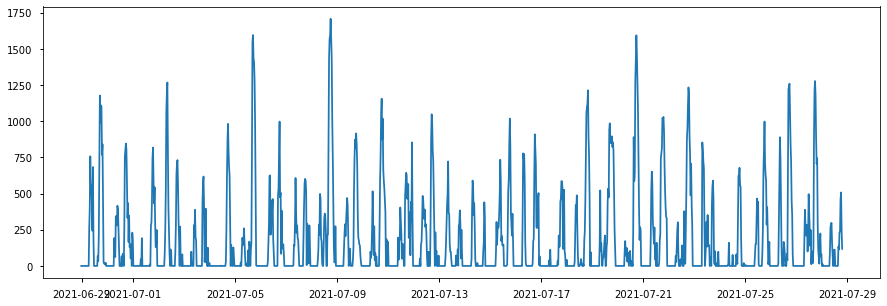

In [319]:
plt.figure(figsize=(15,5))
plt.plot(dff['datetime'], dff['PS'])
plt.show()

In [320]:
#Drop unnecessary columns
#solar, biomass, wind, nuclear, PS, NPSHYD
dff['low_carbon'] = dff['SOLAR'] + dff['BIOMASS'] + dff['WIND'] + dff['NUCLEAR'] + dff['PS'] + dff['NPSHYD']
dff['high_carbon'] = dff['OIL'] + dff['CGST'] + dff['COAL'] + dff['OCGT'] + dff['OTHER'] + dff['INTFR'] + dff['INTIRL'] + dff['INTNED'] + dff['INTEW'] + dff['INTNEM'] + dff['INTELEC'] + dff['INTIFA2'] + dff['INTNSL']
df_main = dff[['low_carbon', 'high_carbon', 'datetime']]
df_main.head()

,low_carbon,high_carbon,datetime
0,8463.0000,15529.0000,2021-06-28 23:30:00+00:00
1,8196.0000,15113.0000,2021-06-29 00:00:00+00:00
2,8226.0000,14851.0000,2021-06-29 00:30:00+00:00
3,8484.0000,14469.0000,2021-06-29 01:00:00+00:00
4,8621.0000,14207.0000,2021-06-29 01:30:00+00:00


In [321]:
df_main.columns

Index(['low_carbon', 'high_carbon', 'datetime'], dtype='object')

In [322]:
#Create function to check for null values

#Original source https://github.com/flatiron-school/Online-DS-FT-022221-Cohort-Notes/blob/master/Phase_3/topic_30_ensemble_methods/topic_30_ensemble_methods-SG.ipynb

def check_nulls(df):
    missingno.matrix(df)
    plt.show()
    null_check = pd.DataFrame({
        '#null':df.isna().sum(),
        '%null':round(df.isna().sum()/len(df)*100,2)
    })
    return null_check

In [323]:
germany_df = df_main.copy()

In [324]:
germany_df

,low_carbon,high_carbon,datetime
0,8463.0000,15529.0000,2021-06-28 23:30:00+00:00
1,8196.0000,15113.0000,2021-06-29 00:00:00+00:00
2,8226.0000,14851.0000,2021-06-29 00:30:00+00:00
3,8484.0000,14469.0000,2021-06-29 01:00:00+00:00
4,8621.0000,14207.0000,2021-06-29 01:30:00+00:00
...,...,...,...
1427,16506.0000,15479.0000,2021-07-28 17:00:00+00:00
1428,16160.0000,15210.0000,2021-07-28 17:30:00+00:00
1429,15449.0000,15525.0000,2021-07-28 18:00:00+00:00
1430,15406.0000,15011.0000,2021-07-28 18:30:00+00:00


In [325]:
germany_df = germany_df.set_index('datetime')

In [326]:
#Double check index is in date time
germany_df.index

DatetimeIndex(['2021-06-28 23:30:00+00:00', '2021-06-29 00:00:00+00:00',
               '2021-06-29 00:30:00+00:00', '2021-06-29 01:00:00+00:00',
               '2021-06-29 01:30:00+00:00', '2021-06-29 02:00:00+00:00',
               '2021-06-29 02:30:00+00:00', '2021-06-29 03:00:00+00:00',
               '2021-06-29 03:30:00+00:00', '2021-06-29 04:00:00+00:00',
               ...
               '2021-07-28 14:30:00+00:00', '2021-07-28 15:00:00+00:00',
               '2021-07-28 15:30:00+00:00', '2021-07-28 16:00:00+00:00',
               '2021-07-28 16:30:00+00:00', '2021-07-28 17:00:00+00:00',
               '2021-07-28 17:30:00+00:00', '2021-07-28 18:00:00+00:00',
               '2021-07-28 18:30:00+00:00', '2021-07-28 19:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='datetime', length=1432, freq=None)

In [327]:
germany_df = germany_df.iloc[1:]
germany_df

,low_carbon,high_carbon
datetime,,
2021-06-29 00:00:00+00:00,8196.0000,15113.0000
2021-06-29 00:30:00+00:00,8226.0000,14851.0000
2021-06-29 01:00:00+00:00,8484.0000,14469.0000
2021-06-29 01:30:00+00:00,8621.0000,14207.0000
2021-06-29 02:00:00+00:00,8658.0000,14073.0000
...,...,...
2021-07-28 17:00:00+00:00,16506.0000,15479.0000
2021-07-28 17:30:00+00:00,16160.0000,15210.0000
2021-07-28 18:00:00+00:00,15449.0000,15525.0000


<AxesSubplot:xlabel='datetime'>

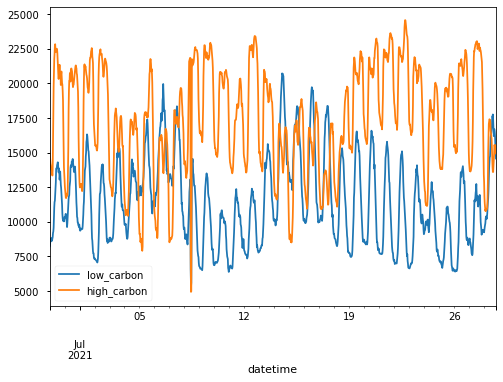

In [328]:
germany_df.plot()

In [329]:
germany_df['ratio'] = germany_df['low_carbon'] / germany_df['high_carbon']

<AxesSubplot:xlabel='datetime'>

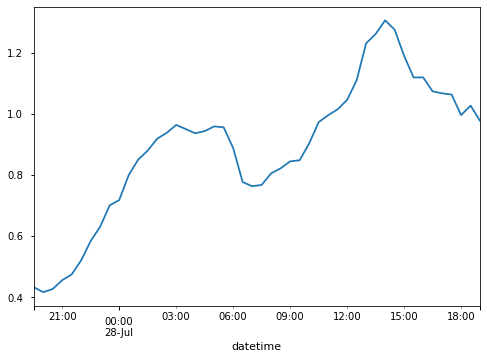

In [330]:
germany_df['ratio'].iloc[-48:].plot()

In [331]:
# Save cleaned dataset as CSV file
germany_df.to_csv('data/cleaned_energy_data.csv')

# Low carbon Modeling

<AxesSubplot:xlabel='datetime'>

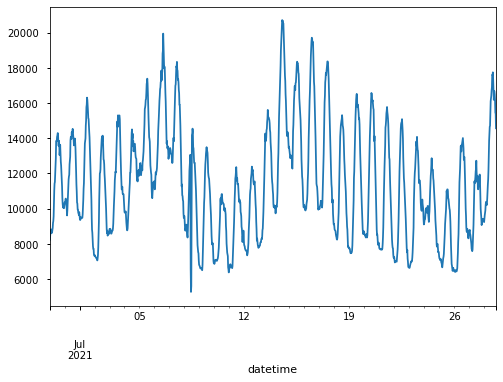

In [332]:
solar_ts = germany_df['low_carbon']
solar_ts.plot()

In [333]:
#Create function to create train test split
def train_test_split(ts):
    
    tts_cutoff = round(len(ts)*0.9)
    display(tts_cutoff)

    ## Use the tts cutoff to do Train test split and plot
    train = ts.iloc[:tts_cutoff]
    test = ts.iloc[tts_cutoff:]
    
    return train, test

In [334]:
solar_ts

datetime
2021-06-29 00:00:00+00:00    8196.0000
2021-06-29 00:30:00+00:00    8226.0000
2021-06-29 01:00:00+00:00    8484.0000
2021-06-29 01:30:00+00:00    8621.0000
2021-06-29 02:00:00+00:00    8658.0000
                               ...    
2021-07-28 17:00:00+00:00   16506.0000
2021-07-28 17:30:00+00:00   16160.0000
2021-07-28 18:00:00+00:00   15449.0000
2021-07-28 18:30:00+00:00   15406.0000
2021-07-28 19:00:00+00:00   14567.0000
Name: low_carbon, Length: 1431, dtype: float64

In [335]:
train, test = train_test_split(solar_ts)

1288

In [336]:
train

datetime
2021-06-29 00:00:00+00:00   8196.0000
2021-06-29 00:30:00+00:00   8226.0000
2021-06-29 01:00:00+00:00   8484.0000
2021-06-29 01:30:00+00:00   8621.0000
2021-06-29 02:00:00+00:00   8658.0000
                               ...   
2021-07-25 17:30:00+00:00   9656.0000
2021-07-25 18:00:00+00:00   9244.0000
2021-07-25 18:30:00+00:00   8413.0000
2021-07-25 19:00:00+00:00   7861.0000
2021-07-25 19:30:00+00:00   7403.0000
Name: low_carbon, Length: 1288, dtype: float64

In [337]:
#Create function to plot train test split for the time series
def plot_train_test_split(train, test):
    
    ## Plot
    ax = train.plot(label='train')
    test.plot(label='test')
    ax.legend()
    
    return ax

<AxesSubplot:xlabel='datetime'>

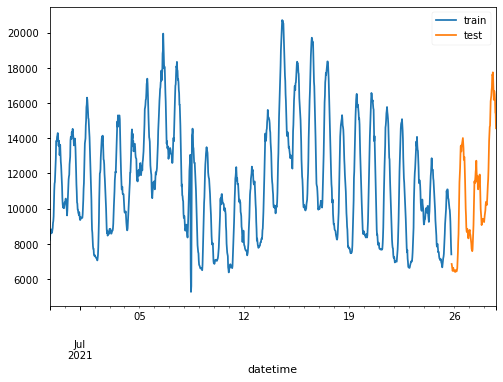

In [338]:
plot_train_test_split(train, test)

In [339]:
#Create Dickey Fuller Test test function
def adfuller_test_df(ts,index=['AD Fuller Results']):
    
    """Adapted from https://github.com/flatiron-school/Online-DS-FT-022221-Cohort-Notes/blob/master/Phase_4/topic_38_time_series_models/ts_functions.py
    Returns the AD Fuller Test Results and p-values for the null hypothesis
    that there the data is non-stationary (that there is a unit root in the data)"""
    
    df_res = tsa.stattools.adfuller(ts)

    names = ['Test Statistic','p-value','#Lags Used','# of Observations Used']
    res  = dict(zip(names,df_res[:4]))
    
    res['p<.05'] = res['p-value']<.05
    res['Stationary?'] = res['p<.05']
    
    if isinstance(index,str):
        index = [index]
    res_df = pd.DataFrame(res,index=index)
    res_df = res_df[['Test Statistic','#Lags Used',
                     '# of Observations Used','p-value','p<.05',
                    'Stationary?']]
    return res_df

In [340]:
#Create Stationarity evaluation function
def stationarity_check(TS,window=4,plot=True,index=['AD Fuller Results']):
    """Adapted from https://github.com/learn-co-curriculum/dsc-removing-trends-lab/tree/solution"""
    
    # Calculate rolling statistics
    roll_mean = TS.rolling(window=window, center=False).mean()
    roll_std = TS.rolling(window=window, center=False).std()
    
    # Perform the Dickey Fuller Test
    dftest = adfuller_test_df(TS,index=index)
    
    if plot:
        
        ## Building in contingency if not a series with a freq
        try: 
            freq = TS.index.freq
        except:
            freq = 'N/A'
            
        # Plot rolling statistics:
        fig = plt.figure(figsize=(12,6))
        plt.plot(TS, color='blue',label=f'Original (freq={freq}')
        plt.plot(roll_mean, color='red', label=f'Rolling Mean (window={window})')
        plt.plot(roll_std, color='black', label = f'Rolling Std (window={window})')
        plt.legend(loc='best')
        plt.title('Rolling Mean & Standard Deviation')
        display(dftest)
        plt.show(block=False)
        
    return dftest

In [341]:
test

datetime
2021-07-25 20:00:00+00:00    6858.6000
2021-07-25 20:30:00+00:00    6759.2700
2021-07-25 21:00:00+00:00    6619.6420
2021-07-25 21:30:00+00:00    6464.0000
2021-07-25 22:00:00+00:00    6512.0000
                               ...    
2021-07-28 17:00:00+00:00   16506.0000
2021-07-28 17:30:00+00:00   16160.0000
2021-07-28 18:00:00+00:00   15449.0000
2021-07-28 18:30:00+00:00   15406.0000
2021-07-28 19:00:00+00:00   14567.0000
Name: low_carbon, Length: 143, dtype: float64

,Test Statistic,#Lags Used,# of Observations Used,p-value,p<.05,Stationary?
AD Fuller Results,-4.0517,23,1264,0.0012,True,True


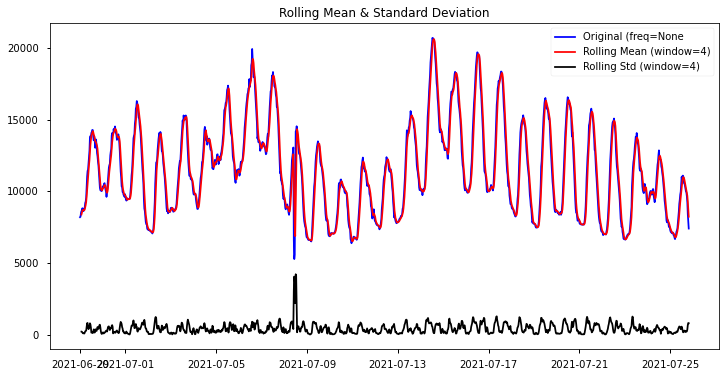

,Test Statistic,#Lags Used,# of Observations Used,p-value,p<.05,Stationary?
AD Fuller Results,-4.0517,23,1264,0.0012,True,True


In [342]:
#Check time series for stationarity
stationarity_check(train)

From the low p value, we can determine that the time series is stationary

### Sktime

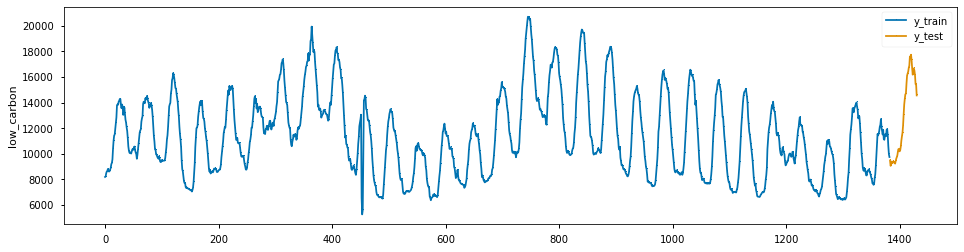

In [343]:
y = solar_ts.reset_index(drop=True)

y_train, y_test = temporal_train_test_split(y, test_size=48)
forecast_horizon = np.arange(y_test.shape[0]) + 1

plot_series(y_train, y_test, labels=["y_train", "y_test"], markers=[",", ","])
plt.show()

In [344]:
np.arange(y_test.shape[0])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47])

0.23552686232475092

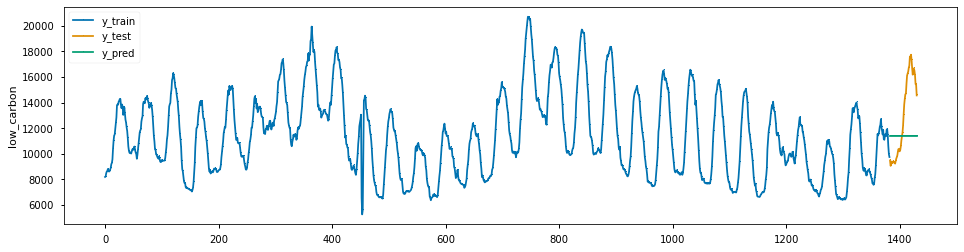

In [345]:
forecaster = NaiveForecaster(strategy="mean")
forecaster.fit(y_train)
y_pred = forecaster.predict(forecast_horizon)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"], markers=[",", ",", ","])
smape = mean_absolute_percentage_error(y_test, y_pred)
smape

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='low_carbon'>)

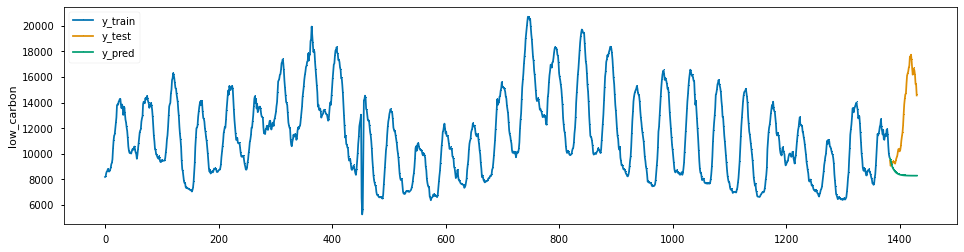

In [346]:
forecaster = AutoARIMA(suppress_warnings=True)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh=forecast_horizon)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"], markers=[",", ",", ","])


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='low_carbon'>)

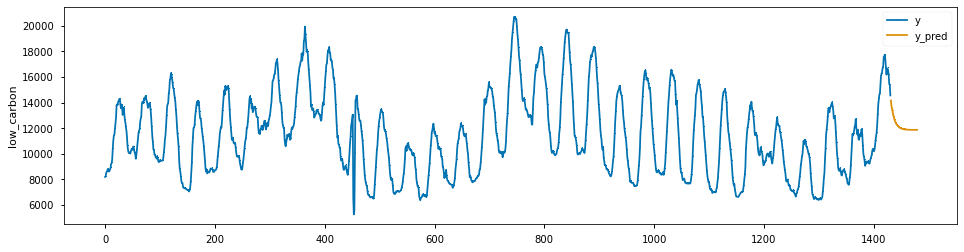

In [347]:
forecaster = AutoARIMA(suppress_warnings=True)
forecaster.fit(y)
y_pred = forecaster.predict(fh=forecast_horizon)
plot_series(y, y_pred, labels=["y", "y_pred"], markers=[",", ","])

0.22288248188429702

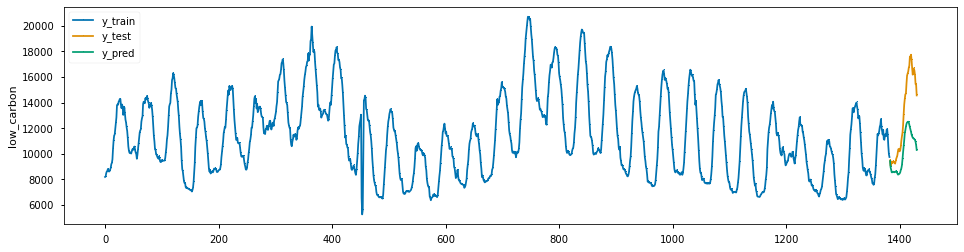

In [348]:
estimator = RandomForestRegressor()
forecaster = DirRecTabularRegressionForecaster(estimator=estimator)
forecaster.fit(y_train, fh=forecast_horizon)
y_pred = forecaster.predict(forecast_horizon)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"], markers=[",", ",", ","])
smape = mean_absolute_percentage_error(y_test, y_pred)
smape

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='low_carbon'>)

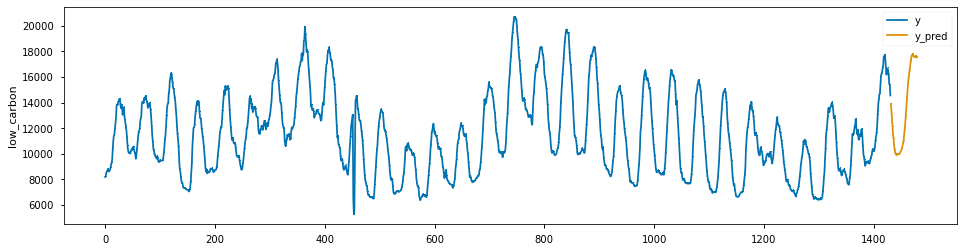

In [350]:
estimator = RandomForestRegressor()
forecaster = DirRecTabularRegressionForecaster(estimator=estimator, window_length=7)
forecaster.fit(y, fh=forecast_horizon)
y_pred = forecaster.predict(forecast_horizon)

plot_series(y, y_pred, labels=["y", "y_pred"], markers=[",", ","])

0.21009565763096613

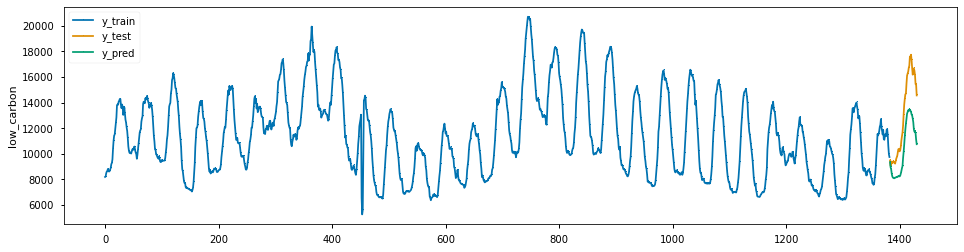

In [351]:
from xgboost import XGBRegressor
estimator = XGBRegressor()
forecaster = DirRecTabularRegressionForecaster(estimator=estimator, window_length=7)
forecaster.fit(y_train, fh=forecast_horizon)
y_pred = forecaster.predict(forecast_horizon)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"], markers=[",", ",", ","])
smape = mean_absolute_percentage_error(y_test, y_pred)
smape

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='low_carbon'>)

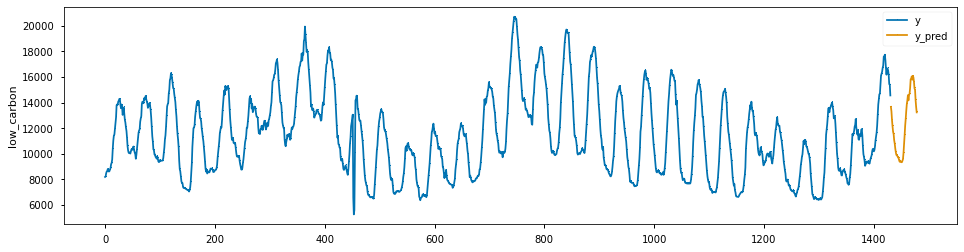

In [352]:
estimator = XGBRegressor()
forecaster = DirRecTabularRegressionForecaster(estimator=estimator, window_length=7)
forecaster.fit(y, fh=forecast_horizon)
y_pred = forecaster.predict(forecast_horizon)
y_lowcarbon = y_pred
plot_series(y, y_pred, labels=["y", "y_pred"], markers=[",", ","])

# High carbon Modeling

In [353]:
germany_df

,low_carbon,high_carbon,ratio
datetime,,,
2021-06-29 00:00:00+00:00,8196.0000,15113.0000,0.5423
2021-06-29 00:30:00+00:00,8226.0000,14851.0000,0.5539
2021-06-29 01:00:00+00:00,8484.0000,14469.0000,0.5864
2021-06-29 01:30:00+00:00,8621.0000,14207.0000,0.6068
2021-06-29 02:00:00+00:00,8658.0000,14073.0000,0.6152
...,...,...,...
2021-07-28 17:00:00+00:00,16506.0000,15479.0000,1.0663
2021-07-28 17:30:00+00:00,16160.0000,15210.0000,1.0625
2021-07-28 18:00:00+00:00,15449.0000,15525.0000,0.9951


<AxesSubplot:xlabel='datetime'>

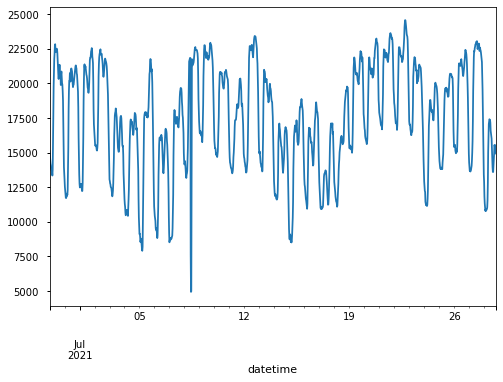

In [354]:
wind_ts = germany_df['high_carbon']
wind_ts.plot()

1288

<AxesSubplot:xlabel='datetime'>

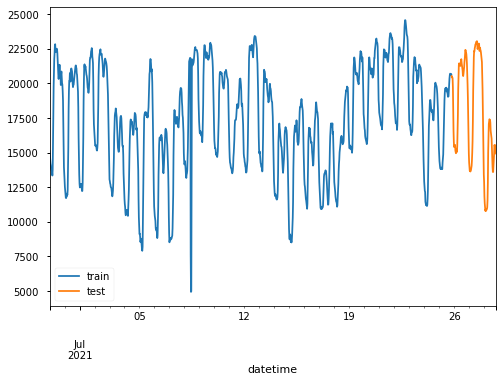

In [355]:
train, test = train_test_split(wind_ts)
plot_train_test_split(train, test)

,Test Statistic,#Lags Used,# of Observations Used,p-value,p<.05,Stationary?
AD Fuller Results,-5.5841,14,1273,0.0000,True,True


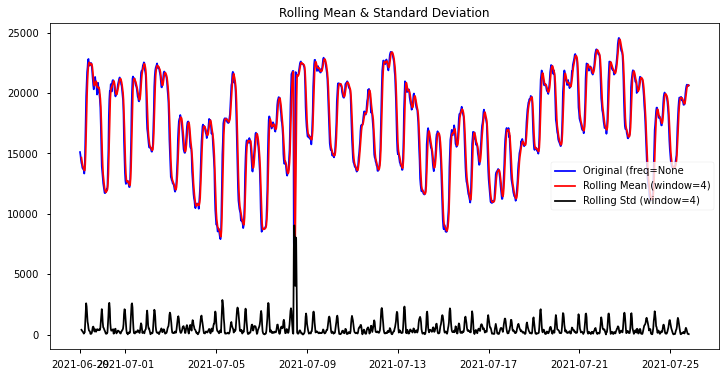

,Test Statistic,#Lags Used,# of Observations Used,p-value,p<.05,Stationary?
AD Fuller Results,-5.5841,14,1273,0.0000,True,True


In [356]:
#Check time series for stationarity
stationarity_check(train)

### Sktime

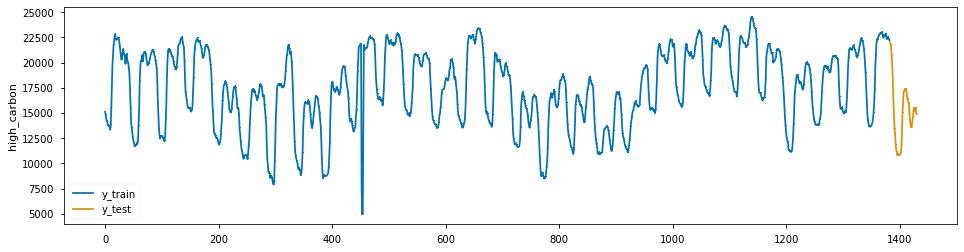

In [357]:
y = wind_ts.reset_index(drop=True)

y_train, y_test = temporal_train_test_split(y, test_size=48)
forecast_horizon = np.arange(y_test.shape[0]) + 1

plot_series(y_train, y_test, labels=["y_train", "y_test"], markers=[",", ","])
plt.show()

0.20960428484576088

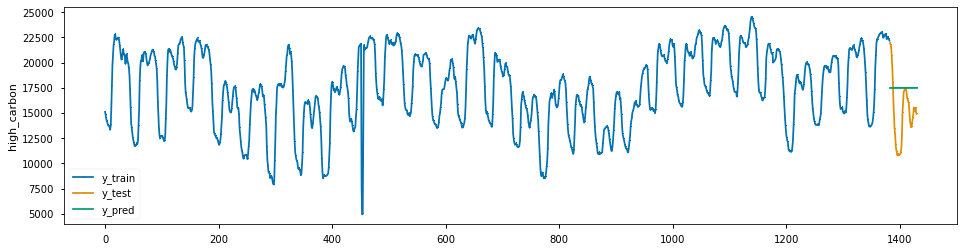

In [358]:
forecaster = NaiveForecaster(strategy="mean")
forecaster.fit(y_train)
y_pred = forecaster.predict(forecast_horizon)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"], markers=[",", ",", ","])
smape = mean_absolute_percentage_error(y_test, y_pred)
smape

0.33372796474445837

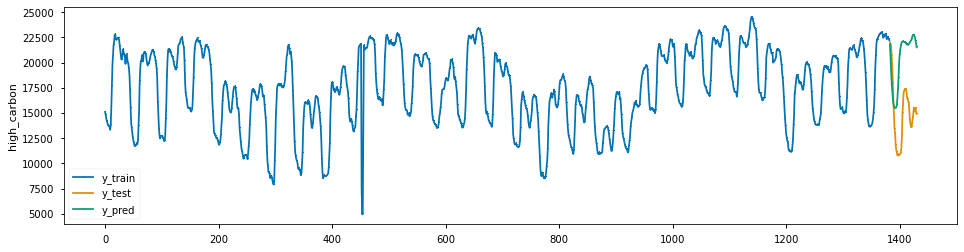

In [359]:
estimator = RandomForestRegressor()
forecaster = DirRecTabularRegressionForecaster(estimator=estimator)
forecaster.fit(y_train, fh=forecast_horizon)
y_pred = forecaster.predict(forecast_horizon)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"], markers=[",", ",", ","])
smape = mean_absolute_percentage_error(y_test, y_pred)
smape

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='high_carbon'>)

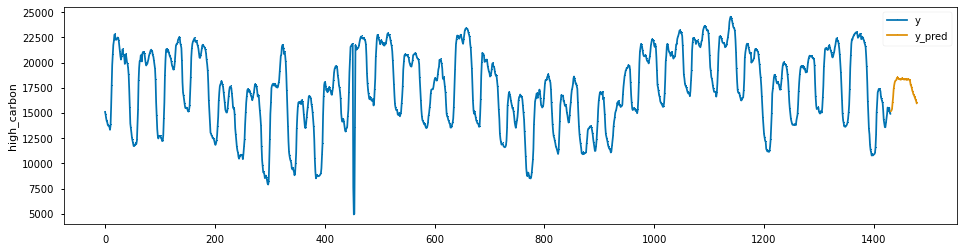

In [360]:
estimator = RandomForestRegressor()
forecaster = DirRecTabularRegressionForecaster(estimator=estimator, window_length=7)
forecaster.fit(y, fh=forecast_horizon)
y_pred = forecaster.predict(forecast_horizon)

plot_series(y, y_pred, labels=["y", "y_pred"], markers=[",", ","])

0.22810200955859775

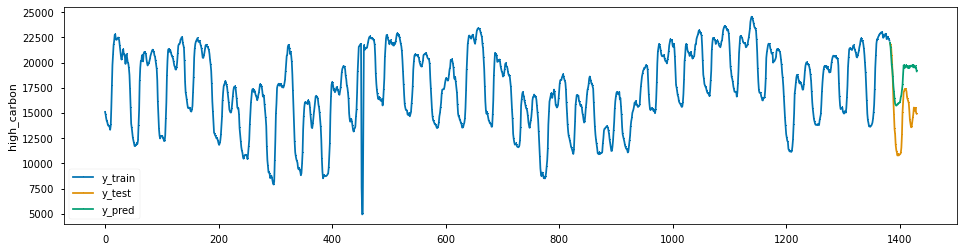

In [361]:
from xgboost import XGBRegressor

estimator = XGBRegressor()
forecaster = DirRecTabularRegressionForecaster(estimator=estimator)
forecaster.fit(y_train, fh=forecast_horizon)
y_pred = forecaster.predict(forecast_horizon)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"], markers=[",", ",", ","])
smape = mean_absolute_percentage_error(y_test, y_pred)
smape

In [362]:
gscv.best_params_

{'window_length': 7}

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='high_carbon'>)

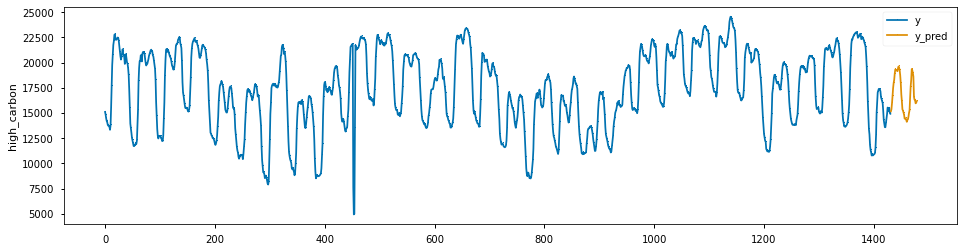

In [363]:
estimator = XGBRegressor()
forecaster = DirRecTabularRegressionForecaster(estimator=estimator, window_length=7)
forecaster.fit(y, fh=forecast_horizon)
y_pred = forecaster.predict(forecast_horizon)
y_highcarbon = y_pred
plot_series(y, y_pred, labels=["y", "y_pred"], markers=[",", ","])

# Ratio modeling

<AxesSubplot:xlabel='datetime'>

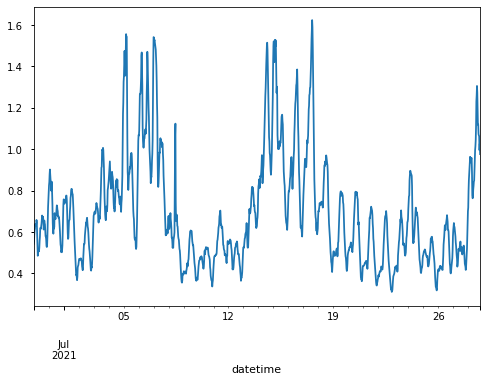

In [364]:
ratio = germany_df['ratio']
ratio.plot()

1288

<AxesSubplot:xlabel='datetime'>

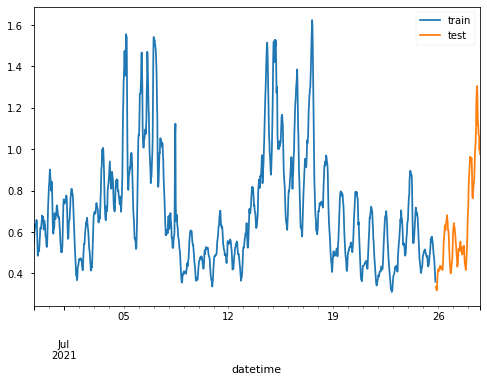

In [365]:
train, test = train_test_split(ratio)
plot_train_test_split(train, test)

,Test Statistic,#Lags Used,# of Observations Used,p-value,p<.05,Stationary?
AD Fuller Results,-3.6300,20,1267,0.0052,True,True


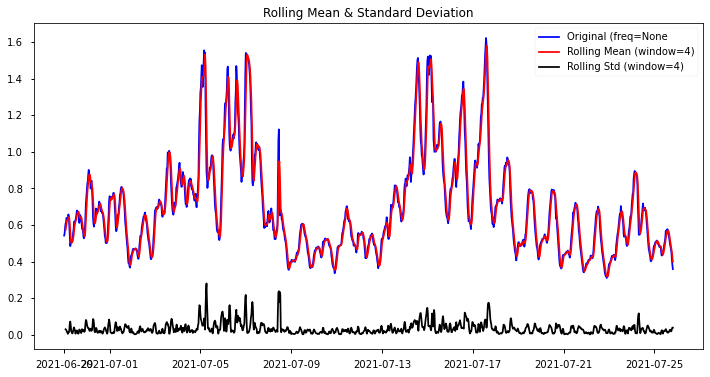

,Test Statistic,#Lags Used,# of Observations Used,p-value,p<.05,Stationary?
AD Fuller Results,-3.6300,20,1267,0.0052,True,True


In [366]:
stationarity_check(train)

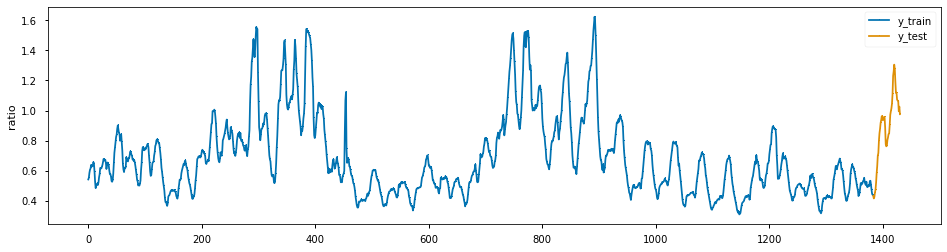

1.9997877207952028

In [367]:
y = ratio.reset_index(drop=True)

y_train, y_test = temporal_train_test_split(y, test_size=48)
forecast_horizon = np.arange(y_test.shape[0]) + 1

plot_series(y_train, y_test, labels=["y_train", "y_test"], markers=[",", ","])
plt.show()
smape = mean_absolute_percentage_error(y_test, y_pred)
smape

0.5170110701432796

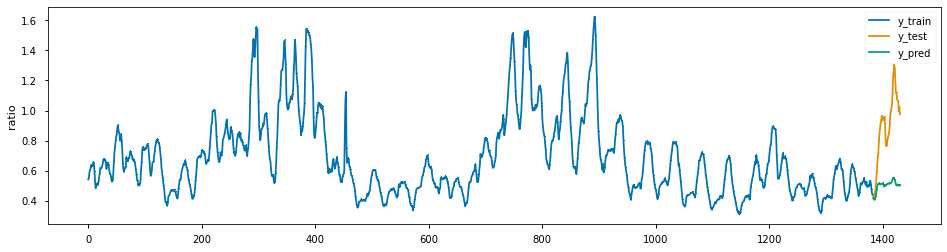

In [368]:
estimator = XGBRegressor()
forecaster = DirRecTabularRegressionForecaster(estimator=estimator)
param_grid = {"window_length": [1, 3, 5, 7]}

cv = SlidingWindowSplitter()
gscv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=param_grid)
gscv.fit(y_train, fh=forecast_horizon)
y_pred = gscv.predict(forecast_horizon)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"], markers=[",", ",", ","])
smape = mean_absolute_percentage_error(y_test, y_pred)
smape

In [369]:
gscv.best_params_

{'window_length': 7}

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='ratio'>)

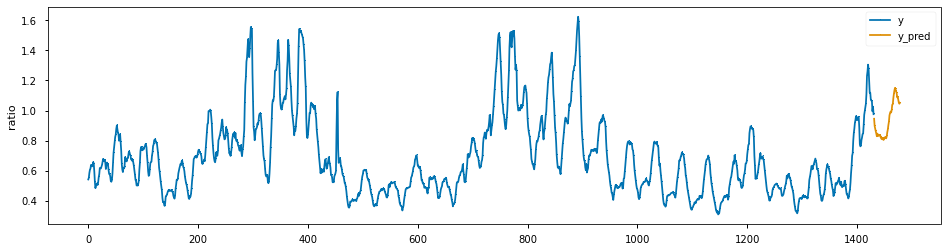

In [370]:
estimator = XGBRegressor()
forecaster = DirRecTabularRegressionForecaster(estimator=estimator, window_length=7)
forecaster.fit(y, fh=forecast_horizon)
y_pred = forecaster.predict(forecast_horizon)
y_ratio = y_pred
plot_series(y, y_pred, labels=["y", "y_pred"], markers=[",", ","])

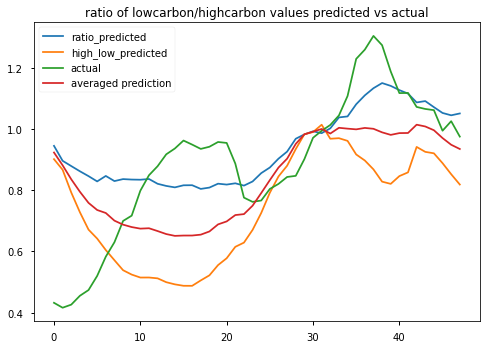

In [371]:
plt.plot(np.array(y_ratio), label = 'ratio_predicted')
plt.plot(np.array(y_lowcarbon/y_highcarbon), label = 'high_low_predicted')
plt.plot(np.array(germany_df['ratio'].iloc[-48:].reset_index(drop=True)), label = 'actual')
plt.plot((np.array(y_ratio) + np.array(y_lowcarbon/y_highcarbon))/2, label = 'averaged prediction')
plt.legend()
plt.title('ratio of lowcarbon/highcarbon values predicted vs actual')
plt.savefig('results/results_comparison')

In [372]:
(np.array(y_ratio) + np.array(y_lowcarbon/y_highcarbon))/2

array([0.92385614, 0.88199862, 0.83620084, 0.79546737, 0.75905027,
       0.73577739, 0.72594289, 0.70093262, 0.68782539, 0.67992025,
       0.67481575, 0.6760545 , 0.66686212, 0.65704005, 0.65113008,
       0.65220778, 0.65227416, 0.6551034 , 0.66554664, 0.68868243,
       0.69843459, 0.7191977 , 0.72230728, 0.74986527, 0.79120326,
       0.8335761 , 0.87460346, 0.90373452, 0.95200005, 0.98338549,
       0.99199256, 1.00092565, 0.98590561, 1.00467412, 1.00193168,
       0.99961349, 1.00428923, 1.0014537 , 0.98981708, 0.98155198,
       0.98735486, 0.98772856, 1.0149131 , 1.00904373, 0.99673721,
       0.97114409, 0.94924032, 0.93534111])

In [373]:
df_price = pd.read_csv('data/csv_agile_A_Eastern_England.csv')

In [374]:
df_price.columns = ['datetime_utc', 'datetime_uk', 'zone', 'DNoS', 'price']

In [375]:
df_price.head()

,datetime_utc,datetime_uk,zone,DNoS,price
0,2018-02-19T00:30:00Z,00:30,A,Eastern_England,9.7755
1,2018-02-19T01:00:00Z,01:00,A,Eastern_England,9.8805
2,2018-02-19T01:30:00Z,01:30,A,Eastern_England,9.3975
3,2018-02-19T02:00:00Z,02:00,A,Eastern_England,9.5445
4,2018-02-19T02:30:00Z,02:30,A,Eastern_England,9.5445


In [376]:
df_price['datetime_utc'] = pd.to_datetime(df_price['datetime_utc'], utc = True)

In [377]:
df_price.head()

,datetime_utc,datetime_uk,zone,DNoS,price
0,2018-02-19 00:30:00+00:00,00:30,A,Eastern_England,9.7755
1,2018-02-19 01:00:00+00:00,01:00,A,Eastern_England,9.8805
2,2018-02-19 01:30:00+00:00,01:30,A,Eastern_England,9.3975
3,2018-02-19 02:00:00+00:00,02:00,A,Eastern_England,9.5445
4,2018-02-19 02:30:00+00:00,02:30,A,Eastern_England,9.5445


In [378]:
df_price.tail()

,datetime_utc,datetime_uk,zone,DNoS,price
60326,2021-07-29 19:30:00+00:00,20:30,A,Eastern_England,25.1370
60327,2021-07-29 20:00:00+00:00,21:00,A,Eastern_England,25.7565
60328,2021-07-29 20:30:00+00:00,21:30,A,Eastern_England,24.6960
60329,2021-07-29 21:00:00+00:00,22:00,A,Eastern_England,23.1315
60330,2021-07-29 21:30:00+00:00,22:30,A,Eastern_England,20.7690


In [379]:
df_price.head()

,datetime_utc,datetime_uk,zone,DNoS,price
0,2018-02-19 00:30:00+00:00,00:30,A,Eastern_England,9.7755
1,2018-02-19 01:00:00+00:00,01:00,A,Eastern_England,9.8805
2,2018-02-19 01:30:00+00:00,01:30,A,Eastern_England,9.3975
3,2018-02-19 02:00:00+00:00,02:00,A,Eastern_England,9.5445
4,2018-02-19 02:30:00+00:00,02:30,A,Eastern_England,9.5445


In [380]:
df_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60331 entries, 0 to 60330
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   datetime_utc  60331 non-null  datetime64[ns, UTC]
 1   datetime_uk   60331 non-null  object             
 2   zone          60331 non-null  object             
 3   DNoS          60331 non-null  object             
 4   price         60331 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(1), object(3)
memory usage: 2.3+ MB


In [381]:
df_price.drop(columns=['datetime_uk', 'zone', 'DNoS'], inplace=True)

In [382]:
df_price = df_price.set_index('datetime_utc')

In [383]:
df_price.index

DatetimeIndex(['2018-02-19 00:30:00+00:00', '2018-02-19 01:00:00+00:00',
               '2018-02-19 01:30:00+00:00', '2018-02-19 02:00:00+00:00',
               '2018-02-19 02:30:00+00:00', '2018-02-19 03:00:00+00:00',
               '2018-02-19 03:30:00+00:00', '2018-02-19 04:00:00+00:00',
               '2018-02-19 04:30:00+00:00', '2018-02-19 05:00:00+00:00',
               ...
               '2021-07-29 17:00:00+00:00', '2021-07-29 17:30:00+00:00',
               '2021-07-29 18:00:00+00:00', '2021-07-29 18:30:00+00:00',
               '2021-07-29 19:00:00+00:00', '2021-07-29 19:30:00+00:00',
               '2021-07-29 20:00:00+00:00', '2021-07-29 20:30:00+00:00',
               '2021-07-29 21:00:00+00:00', '2021-07-29 21:30:00+00:00'],
              dtype='datetime64[ns, UTC]', name='datetime_utc', length=60331, freq=None)

<AxesSubplot:xlabel='datetime_utc'>

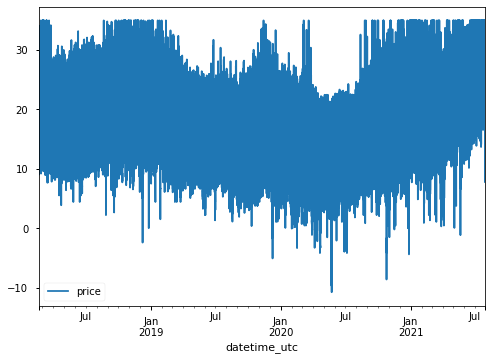

In [384]:
df_price.plot()

In [385]:
l = (pd.DataFrame(columns=['NULL'],
                  index=pd.date_range(germany_df.index.max() + datetime.timedelta(minutes=30), germany_df.index.max() + datetime.timedelta(days =1),
                                      freq='30T')))

In [386]:
l.shape

(48, 1)

In [387]:
l['ratio']= np.array(germany_df['ratio'].iloc[-48:].reset_index(drop=True))
l['ratio_predicted'] = np.array(y_ratio)
l['low_high_ratio_predicted'] = np.array(y_lowcarbon/y_highcarbon)
l['averaged_prediction'] = (np.array(y_ratio) + np.array(y_lowcarbon/y_highcarbon))/2

In [388]:
l.head()

,NULL,ratio,ratio_predicted,low_high_ratio_predicted,averaged_prediction
2021-07-28 19:30:00+00:00,NaN,0.4321,0.9456,0.9021,0.9239
2021-07-28 20:00:00+00:00,NaN,0.4161,0.8967,0.8673,0.8820
2021-07-28 20:30:00+00:00,NaN,0.4262,0.8795,0.7929,0.8362
2021-07-28 21:00:00+00:00,NaN,0.4551,0.8625,0.7285,0.7955
2021-07-28 21:30:00+00:00,NaN,0.4739,0.8466,0.6715,0.7591


In [389]:
l.index

DatetimeIndex(['2021-07-28 19:30:00+00:00', '2021-07-28 20:00:00+00:00',
               '2021-07-28 20:30:00+00:00', '2021-07-28 21:00:00+00:00',
               '2021-07-28 21:30:00+00:00', '2021-07-28 22:00:00+00:00',
               '2021-07-28 22:30:00+00:00', '2021-07-28 23:00:00+00:00',
               '2021-07-28 23:30:00+00:00', '2021-07-29 00:00:00+00:00',
               '2021-07-29 00:30:00+00:00', '2021-07-29 01:00:00+00:00',
               '2021-07-29 01:30:00+00:00', '2021-07-29 02:00:00+00:00',
               '2021-07-29 02:30:00+00:00', '2021-07-29 03:00:00+00:00',
               '2021-07-29 03:30:00+00:00', '2021-07-29 04:00:00+00:00',
               '2021-07-29 04:30:00+00:00', '2021-07-29 05:00:00+00:00',
               '2021-07-29 05:30:00+00:00', '2021-07-29 06:00:00+00:00',
               '2021-07-29 06:30:00+00:00', '2021-07-29 07:00:00+00:00',
               '2021-07-29 07:30:00+00:00', '2021-07-29 08:00:00+00:00',
               '2021-07-29 08:30:00+00:00', '2021-0

In [390]:
df_final = df_price.join(l, how='inner')
df_final.to_csv('data/prediction_data_withprice.csv')

In [391]:
df_final.head()

,price,NULL,ratio,ratio_predicted,low_high_ratio_predicted,averaged_prediction
2021-07-28 19:30:00+00:00,21.8295,NaN,0.4321,0.9456,0.9021,0.9239
2021-07-28 20:00:00+00:00,21.6090,NaN,0.4161,0.8967,0.8673,0.8820
2021-07-28 20:30:00+00:00,20.2860,NaN,0.4262,0.8795,0.7929,0.8362
2021-07-28 21:00:00+00:00,25.1370,NaN,0.4551,0.8625,0.7285,0.7955
2021-07-28 21:30:00+00:00,19.1835,NaN,0.4739,0.8466,0.6715,0.7591


In [392]:
df_final.tail()

,price,NULL,ratio,ratio_predicted,low_high_ratio_predicted,averaged_prediction
2021-07-29 17:00:00+00:00,34.9965,NaN,1.0663,1.0921,0.9260,1.0090
2021-07-29 17:30:00+00:00,34.9965,NaN,1.0625,1.0723,0.9212,0.9967
2021-07-29 18:00:00+00:00,26.0190,NaN,0.9951,1.0532,0.8890,0.9711
2021-07-29 18:30:00+00:00,26.0190,NaN,1.0263,1.0456,0.8529,0.9492
2021-07-29 19:00:00+00:00,26.0190,NaN,0.9759,1.0516,0.8191,0.9353


In [393]:
print(df_price.shape, l.shape, df_final.shape)

(60331, 1) (48, 5) (48, 6)


<AxesSubplot:xlabel='datetime_utc'>

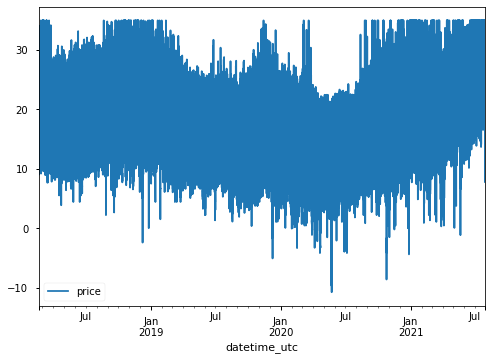

In [394]:
df_price.plot()

<AxesSubplot:>

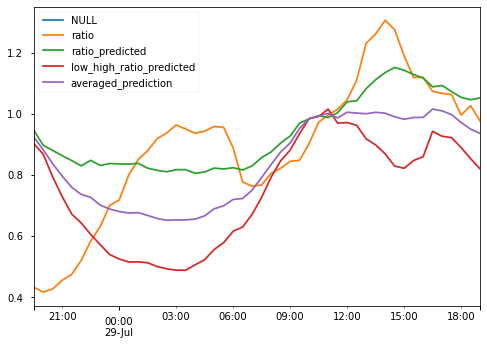

In [395]:
l.plot()

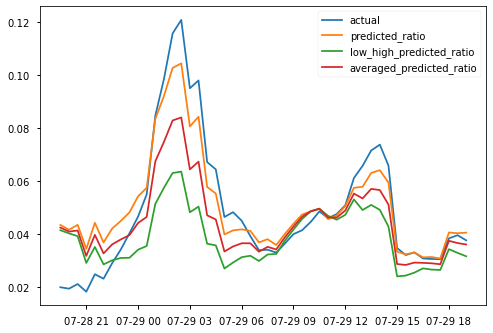

In [408]:
plt.plot(df_final['ratio']/df_final['price'], label = 'actual')
plt.plot(df_final['ratio_predicted']/df_final['price'], label = 'predicted_ratio')
plt.plot(df_final['low_high_ratio_predicted']/df_final['price'], label = 'low_high_predicted_ratio')
plt.plot(df_final['averaged_prediction']/df_final['price'], label = 'averaged_predicted_ratio')
plt.legend()

In [439]:
user_input = 3# input in terms of hours

In [440]:
xx = np.asarray(df_final['averaged_prediction']/df_final['price'])

In [441]:
xx

array([0.04232145, 0.04081626, 0.04122059, 0.03164528, 0.03956787,
       0.03256228, 0.0359716 , 0.03784325, 0.03948594, 0.04405055,
       0.04636953, 0.06734952, 0.07471844, 0.08277149, 0.08391392,
       0.06430127, 0.0672309 , 0.04694567, 0.04540501, 0.03329381,
       0.03519449, 0.0363948 , 0.03639744, 0.03321662, 0.03504776,
       0.03405757, 0.03865224, 0.04269343, 0.04642431, 0.04847607,
       0.04943772, 0.04614049, 0.04609513, 0.04879309, 0.05515726,
       0.05333405, 0.0569325 , 0.05650269, 0.05101098, 0.02855258,
       0.02821296, 0.02910563, 0.02900042, 0.0288327 , 0.02848105,
       0.03732442, 0.03648258, 0.03594839])

In [442]:
N = user_input * 1
moving_aves = np.convolve(xx, np.ones(N)/N, mode='valid')

In [443]:
moving_aves

array([0.04145277, 0.03789404, 0.03747791, 0.03459181, 0.03603392,
       0.03545904, 0.03776693, 0.04045991, 0.04330201, 0.05258987,
       0.0628125 , 0.07494648, 0.08046795, 0.07699556, 0.07181536,
       0.05949261, 0.05319386, 0.0418815 , 0.03796444, 0.03496103,
       0.03599558, 0.03533629, 0.03488728, 0.03410732, 0.03591919,
       0.03846775, 0.04258999, 0.0458646 , 0.0481127 , 0.04801809,
       0.04722445, 0.04700957, 0.05001516, 0.05242814, 0.05514127,
       0.05558975, 0.05481539, 0.04535542, 0.03592551, 0.02862372,
       0.028773  , 0.02897958, 0.02877139, 0.03154606, 0.03409602,
       0.03658513])

In [444]:
df_final.index[np.argmax(moving_aves)]

Timestamp('2021-07-29 01:30:00+0000', tz='UTC')

In [403]:
weather = pd.read_json('energy_dashboard-master/data/weather.json').T

In [404]:
weather

,0,1,2,3,4,5
0,90,0,2021-07-26 09:00:00,17.8700,04d,1.0800
1,92,0.1300,2021-07-26 12:00:00,21.1800,10d,2.5000
2,91,0,2021-07-26 15:00:00,24.8700,04d,2.8200
3,94,0,2021-07-26 18:00:00,21.4600,04d,3.1100
4,100,0.1200,2021-07-26 21:00:00,19.3000,10n,2.3000
5,100,0,2021-07-27 00:00:00,18.3500,04n,2.5500
6,100,0.1200,2021-07-27 03:00:00,17.3100,10n,1.9100
7,100,0.3300,2021-07-27 06:00:00,16.5500,10d,3.2000
8,100,0,2021-07-27 09:00:00,17.0600,04d,4.0400
9,100,1.1400,2021-07-27 12:00:00,16.7600,10d,3.8700
